# Deep Quantile Regression

One area that Deep Learning has not explored extensively is the uncertainty in estimates. However, as far as decision making goes, most people actually require quantiles as opposed to true uncertainty in an estimate. eg. For a given age the weight of an individual will vary. What would be interesting is the (for arguments sake) the 10th and 90th percentile. The uncertainty of _the estimate_ of an individuals weight is less interesting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras.backend as K

%matplotlib inline

mcycle = pd.read_csv('mcycle',delimiter='\t')

Using TensorFlow backend.


Standardise the inputs and outputs so that it is easier to train. I have't saved the mean and standard deviations, but you should.

In [2]:
mcycle.times = (mcycle.times - mcycle.times.mean())/mcycle.times.std()
mcycle.accel = (mcycle.accel - mcycle.accel.mean())/mcycle.accel.std()

In [3]:
model = Sequential()
model.add(Dense(units=10, input_dim=1,activation='relu'))
model.add(Dense(units=10, input_dim=1,activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adadelta')
model.fit(mcycle.times.values, mcycle.accel.values, epochs=2000, batch_size=32, verbose=0)
model.evaluate(mcycle.times.values, mcycle.accel.values)

32/94 [=========>....................] - ETA: 0s

0.29437355094767631

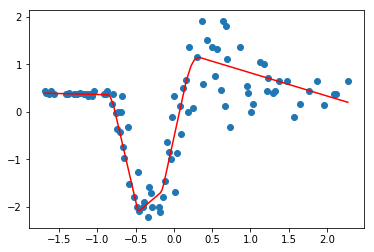

In [4]:
t_test = np.linspace(mcycle.times.min(),mcycle.times.max(),200)
y_test = model.predict(t_test)

plt.scatter(mcycle.times,mcycle.accel)
plt.plot(t_test, y_test,'r')
plt.show()

## Quantiles 0.1, 0.5, 0.9

The loss for an individual data point is defined as:
$$
\begin{align}
\mathcal{L}(\xi_i|\alpha)=\begin{cases}
\alpha \xi_i &\text{if }\xi_i\ge 0, \\
(\alpha-1) \xi_i &\text{if }\xi_i< 0.
\end{cases}
\end{align}
$$
where $\alpha$ is the required quantile and $\xi_i = y_i - f(\mathbf{x}_i)$ and, $f(\mathbf{x}_i)$ is the predicted (quantile) model. The final overall loss is defines as:
$$\mathcal{L}(\mathbf{y},\mathbf{f}|\alpha)=\frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i-f(\mathbf{x}_i)|\alpha)$$

The following function defines the loss function for a quantile model.

**Note**: The following 4 lines is ALL that you change in comparison to a normal Deep Learning method, i.e. The loss function is all that changes.

In [5]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [6]:
def mcycleModel():
    model = Sequential()
    model.add(Dense(units=10, input_dim=1,activation='relu'))
    model.add(Dense(units=10, input_dim=1,activation='relu'))
    model.add(Dense(1))
    
    return model

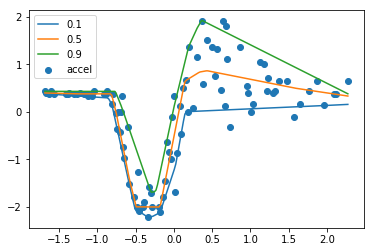

In [7]:
qs = [0.1, 0.5, 0.9]

t_test = np.linspace(mcycle.times.min(),mcycle.times.max(),200)
plt.scatter(mcycle.times,mcycle.accel)

for q in qs:
    model = mcycleModel()
    model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adadelta')
    model.fit(mcycle.times.values, mcycle.accel.values, epochs=2000, batch_size=32, verbose=0)
    
    # Predict the quantile
    y_test = model.predict(t_test)
    plt.plot(t_test, y_test, label=q) # plot out this quantile

plt.legend()    
plt.show()    

## Final Notes

1. Note that the quantile 0.5 is the same as median, which you can attain by minimising Mean Absolute Error, which you can attain in Keras regardless with `loss='mae'`. 
2. Uncertainty and quantiles are **not** the same thing. But most of the time you care about quantiles and not uncertainty.
3. If you really do want uncertainty with deep nets checkout http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html